## Import Libraries and Load Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as  plt

from sklearn.datasets import load_iris

In [2]:
data = load_iris()

print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


The Iris data is in a dictionary form. The key `data` has 150×4 rows of numerical values. `targe` is the class, `target_names` are the class names, and `feature_names` are the feature names. `frame` is a full pandas DataFrame, similar to what we created manually. `filename` is the path to the raw CSV or dataset file inside scikit-learn.

______________

## Exploratory Data Analysis

In [3]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

target_dict = dict(zip([0,1,2], data.target_names))
print(f"Target classes: {target_dict}")

df['target_species'] = df['target'].map(target_dict)

df.head()

Target classes: {0: 'setosa', 1: 'versicolor', 2: 'virginica'}


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
df.shape

(150, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
 5   target_species     150 non-null    object 
dtypes: float64(4), int32(1), object(1)
memory usage: 6.6+ KB


### Let's visualize the dataset

c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


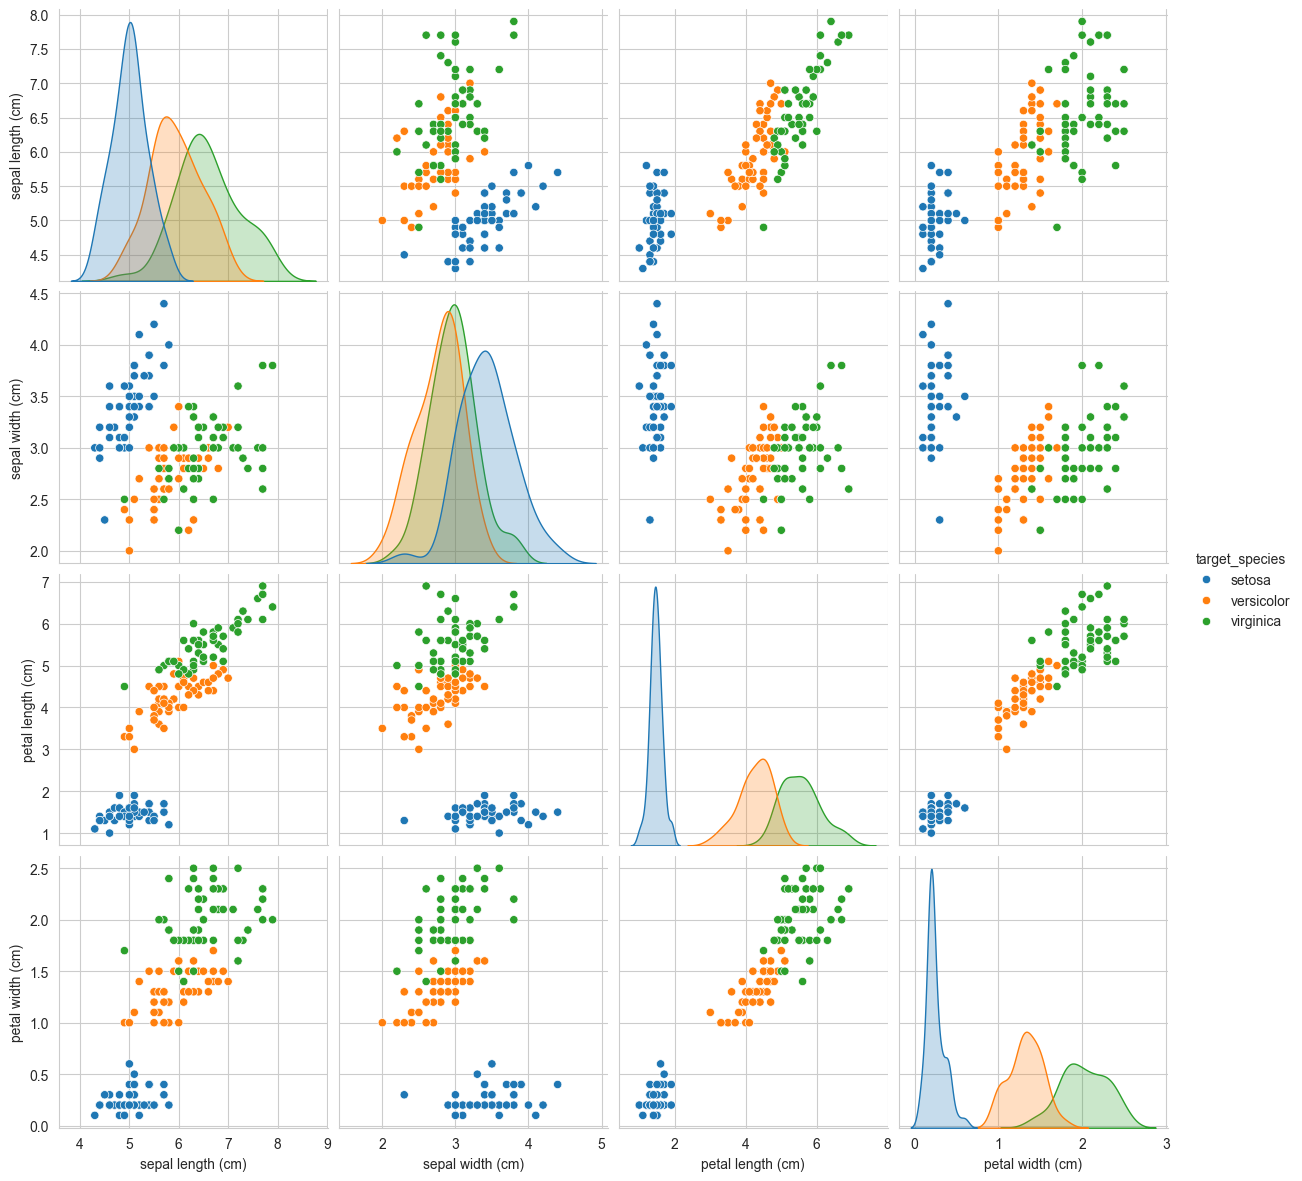

In [6]:
vdf = df.drop(columns='target') # Let's drop target for visualizations

sns.set_style("whitegrid")
sns.pairplot(vdf,hue="target_species",size=3,aspect=1)
plt.show()

- From the above visualization, we can see that `setosa` is clearly separated from other two flowers
- And `virginia` is the longest and `setosa` is the smallest

### Now lets plot the average feature of each species

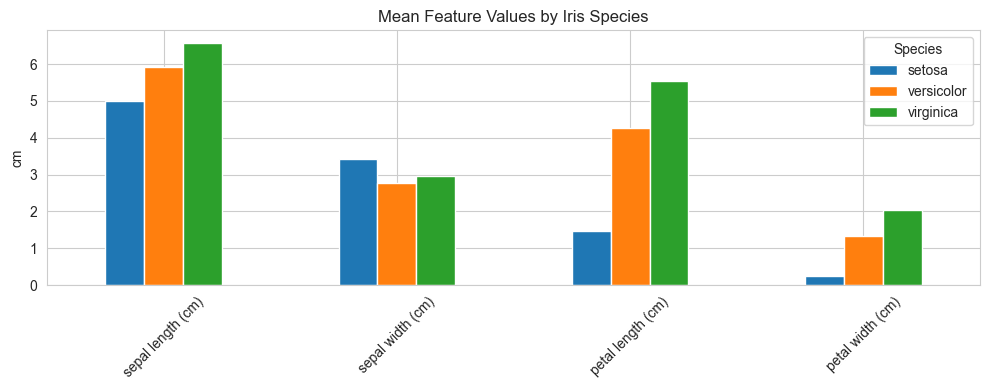

In [7]:
# Bar plot 

mean = vdf.groupby('target_species').mean(numeric_only=True) 

mean.T.plot(kind='bar', figsize=(10, 4))
plt.title('Mean Feature Values by Iris Species')
plt.ylabel('cm')
plt.xticks(rotation=45)
plt.legend(title='Species')
plt.tight_layout()
plt.show()


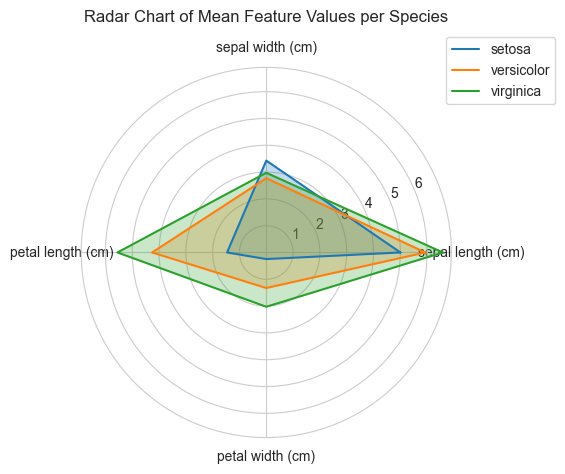

In [8]:
# Radar Plot

labels = mean.columns.tolist()
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for idx, row in mean.iterrows():
    values = row.tolist()
    values += values[:1]  
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Radar Chart of Mean Feature Values per Species', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


_____________________________________

## Build and Evaluate the model

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

# Let's split the data into features and target
X = df.drop(['target', 'target_species'], axis=1)
y = df['target'] 

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

models = {
    "Logistic Regression": LogisticRegression(multi_class='ovr', solver='lbfgs'),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {acc:.2f}")

Logistic Regression: Accuracy = 0.90
Decision Tree: Accuracy = 0.97
SVM: Accuracy = 0.97
Naive Bayes: Accuracy = 0.97
KNN: Accuracy = 0.93


c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


___________________

### Let us now visualize how these model make their decicions using `2 features`.

In [37]:
# Use only the first 2 features for visualization
X_vis = X.iloc[:, :2]
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y, test_size=0.2, random_state=42)

____________

#### Visualizing Decision Boundaries of All the models

In [52]:
# Helper Function
def plot_boundary_subplot(ax, classifier, X_train, X_test, y_train, y_test, title):
    classifier.fit(X_train, y_train)
    
    x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
    y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
    X1, X2 = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = classifier.predict(np.c_[X1.ravel(), X2.ravel()]).reshape(X1.shape)
    
    ax.contourf(X1, X2, Z, alpha=0.3)
    ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, marker='o', edgecolors='k', label='Train', s=10)
    ax.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, marker='s', edgecolors='k', label='Test', s=10)
    ax.set_title(title)
    ax.set_xlabel("Sepal Length")
    ax.set_ylabel("Sepal Width")
    ax.legend(loc='lower right', fontsize='x-small')

c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\rk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarni

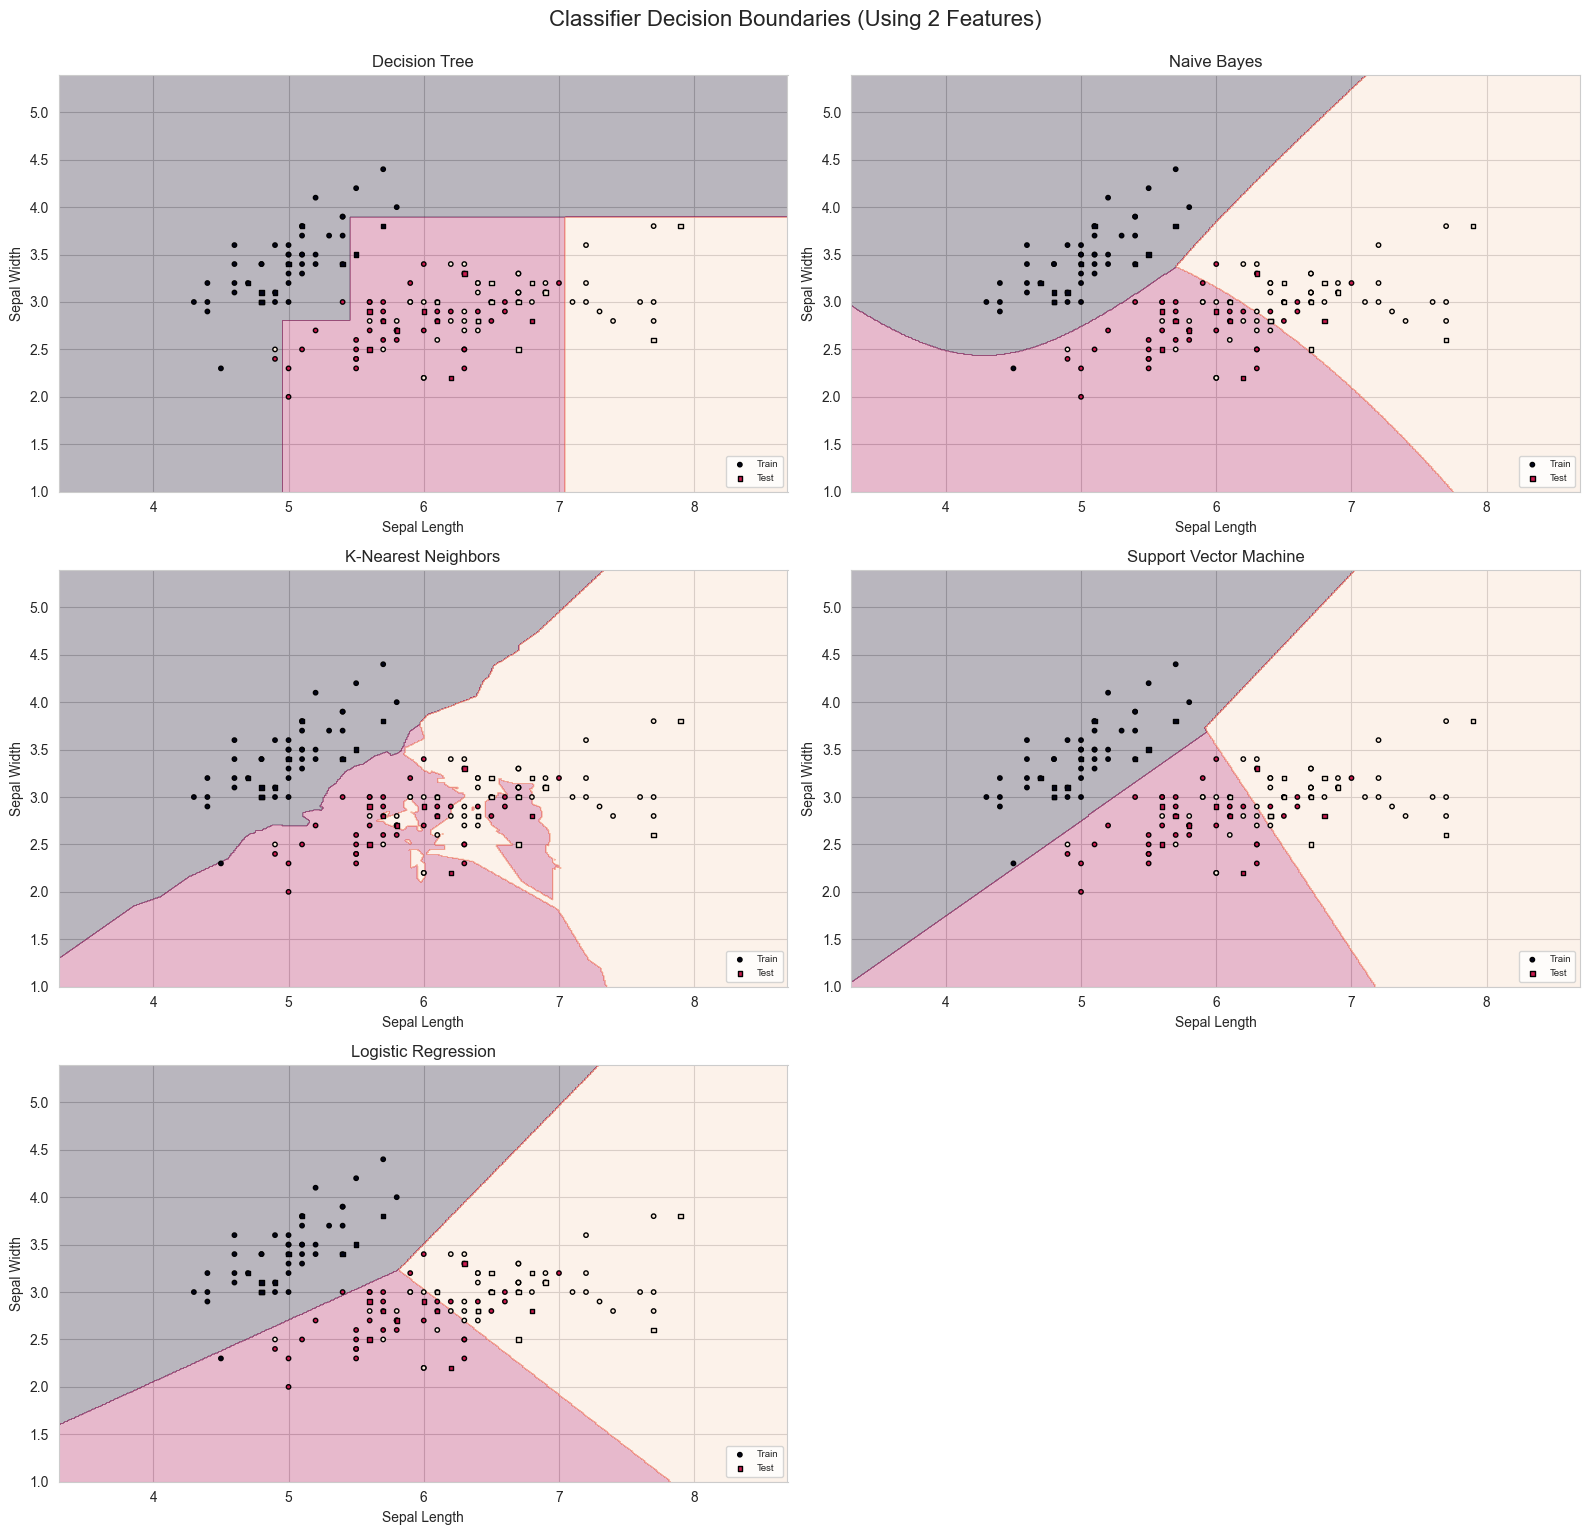

In [53]:
models = [
    (DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=5, min_samples_leaf=3, random_state=0), "Decision Tree"),
    (GaussianNB(), "Naive Bayes"),
    (KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors"),
    (SVC(kernel='linear', probability=True), "Support Vector Machine"),
    (LogisticRegression(multi_class='ovr', solver='lbfgs'), "Logistic Regression")
]

# Create subplots
n_models = len(models)
cols = 2
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 15))
axes = axes.flatten()

# Plot each model
for i, (model, name) in enumerate(models):
    plot_boundary_subplot(axes[i], model, X_train_vis, X_test_vis, y_train_vis, y_test_vis, title=name)

# Turn off unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("Classifier Decision Boundaries (Using 2 Features)", fontsize=16, y=1.02)
plt.show()


__________________________